In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

from models import RecurrentSpaceNet

from scipy import stats

In [2]:
# Simple test dataset maker; square box + bounce off walls

class DatasetMaker(object):
    def __init__(self, chamber_size = 1):
        self.chamber_size = chamber_size
        
    def bounce(self, r, v):
        outside = np.abs(r + v) >= self.chamber_size
        v[outside] = -v[outside]
        return v

    def generate_dataset(self, samples, timesteps):
        stddev = 4*np.pi # von Mises
        r = np.zeros((samples, timesteps, 2))

        s = np.random.rayleigh(0.05, (samples, timesteps))
        prev_hd = np.random.uniform(0, 2*np.pi, samples)
        r[:,0] = np.random.uniform(-self.chamber_size, self.chamber_size, (samples, 2)) 

        for i in range(timesteps - 1):
            hd = np.random.vonmises(prev_hd, stddev, samples)
            prop_v = s[:,i,None]*np.stack((np.cos(hd), np.sin(hd)),axis=-1)
            v = self.bounce(r[:,i], prop_v) 
            prev_hd = np.arctan2(v[:,1], v[:,0])
            r[:,i+1] = r[:,i] + v # dt = 1

        v = np.diff(r, axis = 1)
        
        return torch.tensor(r.astype('float32')), torch.tensor(v.astype('float32'))


In [3]:
## Training parameters
train_steps = 1000

n_in = 2 # Cartesian coordinates, no context
n_out = 500 # no. of spatial representations
timesteps = 250
bs = 32 # batch size

In [4]:
# instantiate model
model = RecurrentSpaceNet(n_in, n_out, scale = 0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

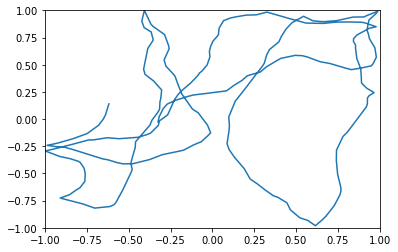

In [5]:
genny = DatasetMaker()
r, v = genny.generate_dataset(1, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

In [6]:
loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps)
    r_label = r[:,1:]
    loss = model.train_step(x = v, y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.049608: 100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


Text(0, 0.5, 'Train Loss')

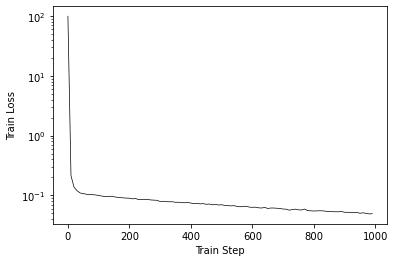

In [13]:
#loss_history = loss_history[1:]
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [8]:
r, v = genny.generate_dataset(1, timesteps*10)
# inference
p,_ = model.spatial_representation(v, model.initial_state(v.shape[0])[None])
p = p.detach().numpy()

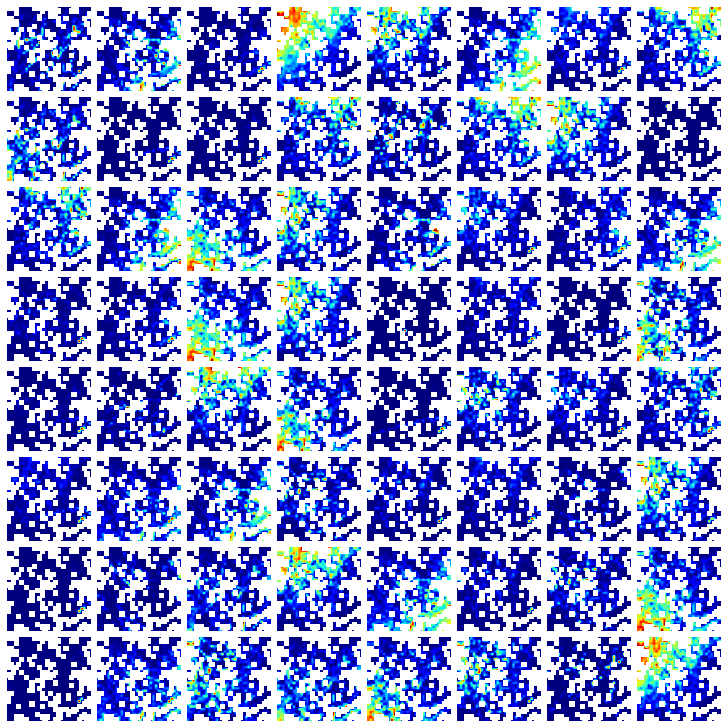

In [9]:
n_show = 8 # show all units in network

fig, ax = plt.subplots(n_show, n_show, figsize = (10,10), constrained_layout = True)

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)

for i in range(n_show**2):
    ax[i//n_show, i%n_show].imshow(ratemaps[i].T, origin = "lower", cmap = "jet")
    ax[i//n_show, i%n_show].axis("off")

In [10]:
label_corr = model.correlation_function(r[:,:-1]).detach().numpy()
corr = model(v).detach().numpy()
loss = (corr - label_corr)**2

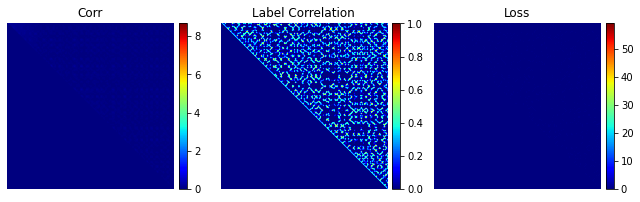

In [11]:
fig, ax = plt.subplots(1,3, figsize = (9, 3))

for i, (val, title) in enumerate(zip([corr, label_corr, loss], ["Corr", "Label Correlation", "Loss"])):
    im = ax[i].imshow(np.mean(val, axis = 0), cmap = "jet")
    ax[i].set_title(title)
    ax[i].axis("off")
    fig.colorbar(im, ax = ax[i], pad = 0.03, fraction = 0.046) 
plt.tight_layout()

Text(0, 0.5, 'Activity')

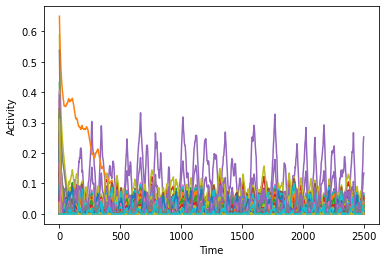

In [12]:
plt.plot(np.mean(p,axis=0));
plt.xlabel("Time")
plt.ylabel("Activity")